In [68]:
# Import Dependencies
from pathlib import Path
import pandas as pd
import requests
import json
from api_key import open_weather_api_key
import numpy as np
from datetime import datetime, timedelta
import calendar
import sklearn.datasets as dta
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
#Create a path variable to the data
cities_data = Path('Resources/Cities_Au.csv')

In [3]:
# Import the data into a Pandas DataFrame
cities_data_df = pd.read_csv(cities_data, encoding="UTF-8")
cities_data_df.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Melbourne,-37.8142,144.9631,Australia,AU,Victoria,admin,5031195,5031195
1,Sydney,-33.8678,151.2100,Australia,AU,New South Wales,admin,4840600,4840600
2,Brisbane,-27.4678,153.0281,Australia,AU,Queensland,admin,2360241,2360241
3,Perth,-31.9559,115.8606,Australia,AU,Western Australia,admin,2141834,2141834
4,Adelaide,-34.9275,138.6000,Australia,AU,South Australia,admin,1295714,1295714


In [4]:
#Clean the dataframe
cleaned_cities_df = cities_data_df.drop(columns=['capital', 'population_proper', 'admin_name'])
cleaned_cities_df.head()

,city,lat,lng,country,iso2,population
0,Melbourne,-37.8142,144.9631,Australia,AU,5031195
1,Sydney,-33.8678,151.2100,Australia,AU,4840600
2,Brisbane,-27.4678,153.0281,Australia,AU,2360241
3,Perth,-31.9559,115.8606,Australia,AU,2141834
4,Adelaide,-34.9275,138.6000,Australia,AU,1295714


In [5]:
#Set up a list of time frame from Jan 2023 to Jan 2024 mothly
time = np.arange(np.datetime64('2020-01-06'), np.datetime64('2021-01-01'),timedelta(days=30))
ux_time = time.astype('datetime64[s]').astype('int')
ux_time

array([1578268800, 1580860800, 1583452800, 1586044800, 1588636800,
       1591228800, 1593820800, 1596412800, 1599004800, 1601596800,
       1604188800, 1606780800, 1609372800])

In [6]:
#Create empty list for storing data
aqi =[]
co = []
no2 =[]

#Loop through all cities/row in dataframe
for index, row in cleaned_cities_df.iterrows():
    lat = row["lat"]
    lon =row["lng"]
    #Loop through all time in time frame
    for i in range(len(ux_time)):
        start_date = ux_time[i]
        end_date = start_date + 1
        daily_url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start_date}&end={end_date}&appid={open_weather_api_key}"
    try:
        data = requests.get(daily_url).json()
        #Add data to respective lists
        aqi.append(data["list"][0]["main"]["aqi"])
        co.append(data["list"][0]["components"]['co'])
        no2.append(data["list"][0]["components"]['no2'])
        #Calculate average data
        average_aqi = sum(aqi) / len(aqi)
        average_co = sum(co) / len(co)
        average_no2 = sum(no2) / len(no2)
        #Add data to dataframe
        cleaned_cities_df.loc[index, "average monthly AQI"] = average_aqi
        cleaned_cities_df.loc[index, "average monthly CO"] = average_co
        cleaned_cities_df.loc[index, "average monthly NO2"] = average_no2
    except (KeyError, IndexError):

        cleaned_cities_df.loc[index, "average monthly AQI"] = np.nan
        cleaned_cities_df.loc[index, "average monthly CO"] = np.nan
        cleaned_cities_df.loc[index, "average monthly NO2"] = np.nan

In [7]:
cleaned_cities_df

,city,lat,lng,country,iso2,population,average monthly AQI,average monthly CO,average monthly NO2
0,Melbourne,-37.8142,144.9631,Australia,AU,5031195,1.000000,195.270000,12.170000
1,Sydney,-33.8678,151.2100,Australia,AU,4840600,1.000000,184.420000,8.355000
2,Brisbane,-27.4678,153.0281,Australia,AU,2360241,1.000000,183.583333,6.796667
3,Perth,-31.9559,115.8606,Australia,AU,2141834,1.250000,190.675000,7.560000
4,Adelaide,-34.9275,138.6000,Australia,AU,1295714,1.200000,189.256000,6.348000
...,...,...,...,...,...,...,...,...,...
312,Yallourn North,-38.1667,146.3667,Australia,AU,1107,1.022364,172.406645,1.845112
313,Innisfail,-17.5238,146.0311,Australia,AU,1091,1.022293,172.447548,1.840446
314,Mollymook,-35.3297,150.4753,Australia,AU,1083,1.022222,172.414032,1.835873
315,Evandale,-41.5702,147.2467,Australia,AU,1058,1.022152,172.380728,1.830633


In [8]:
#According to "", cities with population less than 15,0000 are considered as rural.
#Add classification to dataframe
for index, row in cleaned_cities_df.iterrows():
    if row["population"] > 10000:
        cleaned_cities_df.loc[index, "classification"] = "Urban"
    else:
        cleaned_cities_df.loc[index, "classification"] = "Rural"

cleaned_cities_df

,city,lat,lng,country,iso2,population,average monthly AQI,average monthly CO,average monthly NO2,classification
0,Melbourne,-37.8142,144.9631,Australia,AU,5031195,1.000000,195.270000,12.170000,Urban
1,Sydney,-33.8678,151.2100,Australia,AU,4840600,1.000000,184.420000,8.355000,Urban
2,Brisbane,-27.4678,153.0281,Australia,AU,2360241,1.000000,183.583333,6.796667,Urban
3,Perth,-31.9559,115.8606,Australia,AU,2141834,1.250000,190.675000,7.560000,Urban
4,Adelaide,-34.9275,138.6000,Australia,AU,1295714,1.200000,189.256000,6.348000,Urban
...,...,...,...,...,...,...,...,...,...,...
312,Yallourn North,-38.1667,146.3667,Australia,AU,1107,1.022364,172.406645,1.845112,Rural
313,Innisfail,-17.5238,146.0311,Australia,AU,1091,1.022293,172.447548,1.840446,Rural
314,Mollymook,-35.3297,150.4753,Australia,AU,1083,1.022222,172.414032,1.835873,Rural
315,Evandale,-41.5702,147.2467,Australia,AU,1058,1.022152,172.380728,1.830633,Rural


In [17]:
#Group data by Classification
grouped_city_df = cleaned_cities_df.groupby(["classification"])
#Calculate monthly average data
mean_ru_aqi = grouped_city_df['average monthly AQI'].mean()
mean_ru_co = grouped_city_df['average monthly CO'].mean()
mean_ru_no2 = grouped_city_df['average monthly NO2'].mean()

In [50]:
population_bins = [0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000, 10000000]
group_names = ["<5000", "5000-10000", "10000-15000", "15000-20000", "20000-25000", "25000-30000","30000-35000", "35000-40000", "40000-45000", "45000-50000", "50000-55000", "55000-60000", ">60000"]

In [51]:
cleaned_cities_df["Population Range"] = pd.cut(cleaned_cities_df["population"], population_bins, labels=group_names, include_lowest=True)
cleaned_cities_df

,city,lat,lng,country,iso2,population,average monthly AQI,average monthly CO,average monthly NO2,classification,Population Range
0,Melbourne,-37.8142,144.9631,Australia,AU,5031195,1.000000,195.270000,12.170000,Urban,>60000
1,Sydney,-33.8678,151.2100,Australia,AU,4840600,1.000000,184.420000,8.355000,Urban,>60000
2,Brisbane,-27.4678,153.0281,Australia,AU,2360241,1.000000,183.583333,6.796667,Urban,>60000
3,Perth,-31.9559,115.8606,Australia,AU,2141834,1.250000,190.675000,7.560000,Urban,>60000
4,Adelaide,-34.9275,138.6000,Australia,AU,1295714,1.200000,189.256000,6.348000,Urban,>60000
...,...,...,...,...,...,...,...,...,...,...,...
312,Yallourn North,-38.1667,146.3667,Australia,AU,1107,1.022364,172.406645,1.845112,Rural,<5000
313,Innisfail,-17.5238,146.0311,Australia,AU,1091,1.022293,172.447548,1.840446,Rural,<5000
314,Mollymook,-35.3297,150.4753,Australia,AU,1083,1.022222,172.414032,1.835873,Rural,<5000
315,Evandale,-41.5702,147.2467,Australia,AU,1058,1.022152,172.380728,1.830633,Rural,<5000


In [52]:
grouped_population_air_quality_df = cleaned_cities_df.groupby("Population Range")
mean_range_aqi = grouped_population_air_quality_df["average monthly AQI"].mean()
mean_range_co = grouped_population_air_quality_df["average monthly CO"].mean()
mean_range_no2 = grouped_population_air_quality_df["average monthly NO2"].mean()

/var/folders/14/q1394_052rjg1w_1sd8fyd100000gn/T/ipykernel_38287/3748210896.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_population_air_quality_df = cleaned_cities_df.groupby("Population Range")


In [53]:
health_df = pd.read_excel("Resources/aihw-phe-292-cardiovascular-hospitalisation-data-tables.xlsx", sheet_name= 2)
health_df.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Population Health Area (PHA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Table 1: Hospitalisations with cardiovascular ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,,NaN,Cardiovascular disease as the principal diagnosis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Cardiovascular disease as the principal diagnosis,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,Persons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Females,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Code,Name,Annualised hospitalisations,"Hospitalisations per 100,000",Annualised population,"Age-standardised rate (per 100,000)",95% CI age-standardised rate,Rate ratio (relative to all of Australia),95% CI rate ratio,Percentile rank,...,Percentile rank,NaN,Annualised hospitalisations,"Hospitalisations per 100,000",Annualised population,"Age-standardised rate (per 100,000)",95% CI age-standardised rate,Rate ratio (relative to all of Australia),95% CI rate ratio,Percentile rank


In [54]:
cleaned_column_df = health_df[["Unnamed: 1", "Unnamed: 2", "Unnamed: 4"]]
cleaned_column_df.rename(columns={"Unnamed: 1": "Name", "Unnamed: 2": "Annualised hospitalisations", "Unnamed: 4": "Annualised population"}, inplace=True)
cleaned_column_df

/var/folders/14/q1394_052rjg1w_1sd8fyd100000gn/T/ipykernel_38287/649664724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_column_df.rename(columns={"Unnamed: 1": "Name", "Unnamed: 2": "Annualised hospitalisations", "Unnamed: 4": "Annualised population"}, inplace=True)


,Name,Annualised hospitalisations,Annualised population
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
1178,NaN,NaN,NaN
1179,NaN,NaN,NaN
1180,NaN,NaN,NaN
1181,NaN,NaN,NaN


In [55]:
cleaned_row_df = cleaned_column_df.iloc[11:1176].reset_index().drop(columns=["index"])
cleaned_health_df = cleaned_row_df.loc[(cleaned_row_df['Annualised hospitalisations'] != "n.p.") & (cleaned_row_df['Annualised population'] != "n.p.")]
cleaned_health_df


,Name,Annualised hospitalisations,Annualised population
0,Gosford - South East,654.33,18616.67
1,Calga - Kulnura/ Narara/ Niagara Park - Lisarow,634.67,19895.67
2,Erina - Green Point area,1171.67,28952
3,Gosford - Springfield/ Wyoming,1018.67,31120.83
4,Kariong/ Point Clare - Koolewong,392.67,12910
...,...,...,...
1159,Weston Creek,591.42,23225
1160,Chifley/ Lyons (ACT)/ O'Malley/ Phillip,195.33,9858.33
1161,Curtin/ Garran/ Hughes,300.33,11961.5
1162,Farrer/ Isaacs/ Mawson/ Pearce/ Torrens,341.33,13835.67


In [56]:
for index, row in cleaned_health_df.iterrows():
    if row["Annualised population"] > 10000:
        cleaned_health_df.loc[index, "Classification"] = "Urban"
    else:
        cleaned_health_df.loc[index, "Classification"] = "Rural"

cleaned_health_df

/var/folders/14/q1394_052rjg1w_1sd8fyd100000gn/T/ipykernel_38287/1257850092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_health_df.loc[index, "Classification"] = "Urban"


,Name,Annualised hospitalisations,Annualised population,Classification
0,Gosford - South East,654.33,18616.67,Urban
1,Calga - Kulnura/ Narara/ Niagara Park - Lisarow,634.67,19895.67,Urban
2,Erina - Green Point area,1171.67,28952,Urban
3,Gosford - Springfield/ Wyoming,1018.67,31120.83,Urban
4,Kariong/ Point Clare - Koolewong,392.67,12910,Urban
...,...,...,...,...
1159,Weston Creek,591.42,23225,Urban
1160,Chifley/ Lyons (ACT)/ O'Malley/ Phillip,195.33,9858.33,Rural
1161,Curtin/ Garran/ Hughes,300.33,11961.5,Urban
1162,Farrer/ Isaacs/ Mawson/ Pearce/ Torrens,341.33,13835.67,Urban


In [57]:
grouped_ru_health_df = cleaned_health_df.groupby("Classification")
mean_ru_hospitalisation = grouped_ru_health_df["Annualised hospitalisations"].mean()

In [58]:
cleaned_health_df["Population Range"] = pd.cut(cleaned_health_df["Annualised population"], population_bins, labels=group_names, include_lowest=True)
cleaned_health_df

/var/folders/14/q1394_052rjg1w_1sd8fyd100000gn/T/ipykernel_38287/1425395901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_health_df["Population Range"] = pd.cut(cleaned_health_df["Annualised population"], population_bins, labels=group_names, include_lowest=True)


,Name,Annualised hospitalisations,Annualised population,Classification,Population Range
0,Gosford - South East,654.33,18616.67,Urban,15000-20000
1,Calga - Kulnura/ Narara/ Niagara Park - Lisarow,634.67,19895.67,Urban,15000-20000
2,Erina - Green Point area,1171.67,28952,Urban,25000-30000
3,Gosford - Springfield/ Wyoming,1018.67,31120.83,Urban,30000-35000
4,Kariong/ Point Clare - Koolewong,392.67,12910,Urban,10000-15000
...,...,...,...,...,...
1159,Weston Creek,591.42,23225,Urban,20000-25000
1160,Chifley/ Lyons (ACT)/ O'Malley/ Phillip,195.33,9858.33,Rural,5000-10000
1161,Curtin/ Garran/ Hughes,300.33,11961.5,Urban,10000-15000
1162,Farrer/ Isaacs/ Mawson/ Pearce/ Torrens,341.33,13835.67,Urban,10000-15000


In [59]:
grouped_health_range_df = cleaned_health_df.groupby("Population Range")
mean_range_hospitalisation = grouped_health_range_df['Annualised hospitalisations'].mean()

/var/folders/14/q1394_052rjg1w_1sd8fyd100000gn/T/ipykernel_38287/2296414876.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_health_range_df = cleaned_health_df.groupby("Population Range")


In [60]:
#Create a new dataframe that contains monthly average data
rural_urban_df = pd.DataFrame({"Monthly Average AQI": mean_ru_aqi,
                               "Montly Average CO": mean_ru_co,
                               "Monthly Average NO2": mean_ru_no2,
                               "Annualised hospitalisations": mean_ru_hospitalisation})

rural_urban_df

,Monthly Average AQI,Montly Average CO,Monthly Average NO2,Annualised hospitalisations
Rural,1.022229,174.491397,2.126486,170.669684
Urban,1.042445,181.844619,3.099934,552.060433


In [61]:
#Create a new dataframe that contains monthly average data
population_range_df = pd.DataFrame({"Monthly Average AQI": mean_range_aqi,
                                    "Montly Average CO": mean_range_co,
                                    "Monthly Average NO2": mean_range_no2,
                                    "Annualised hospitalisations": mean_range_hospitalisation})

population_range_df

,Monthly Average AQI,Montly Average CO,Monthly Average NO2,Annualised hospitalisations
Population Range,,,,
<5000,1.026265,173.475488,1.996627,92.171818
5000-10000,1.014446,176.450651,2.376928,202.650296
10000-15000,1.016112,180.310187,2.574327,318.794471
15000-20000,1.020924,181.561705,2.400308,455.47758
20000-25000,1.024400,182.387183,2.507308,544.196648
25000-30000,1.026690,182.916905,2.473160,675.759774
30000-35000,1.029884,182.278423,2.393358,697.676778
35000-40000,1.032796,181.144237,2.173780,776.485455
40000-45000,1.035099,181.361145,2.060733,825.924773


The correlation between average NO2 and the annualised hospitalisations is 0.8


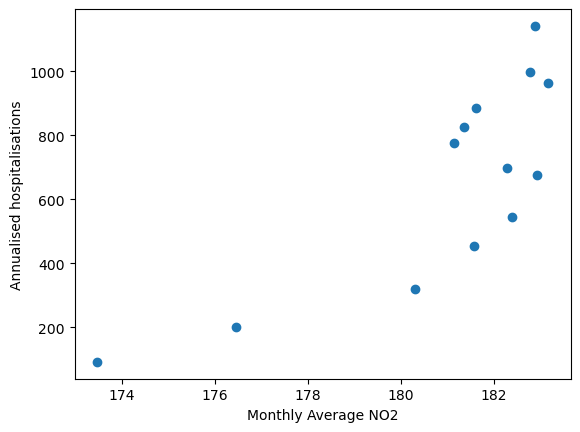

In [110]:
x_values = population_range_df["Montly Average CO"]
y_values = population_range_df["Annualised hospitalisations"]
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between average NO2 and the annualised hospitalisations is {round(correlation[0],2)}")
plt.scatter(x_values, y_values)
# (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# regress_values = x_values * slope + intercept
# line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# plt.figure(figsize=(8,6))
# plt.plot(x_values,regress_values,"r-")
# plt.annotate(line_eq,(20,36),fontsize=15,color="red")
plt.xlabel("Monthly Average NO2")
plt.ylabel("Annualised hospitalisations")
plt.show()